<a href="https://colab.research.google.com/github/josephxlp/PostHurricaneDamageClassification/blob/main/PlantVillageClassification_101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub --q

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os

Mounted at /content/gdrive


In [6]:
from google.colab import userdata
credentials = userdata.get('solakaggle')

In [18]:
path = "/content/gdrive/MyDrive/PROJx/PlantVillage"
os.chdir(path)

In [7]:
credentials

'{"username":"fiatfux","key":"576ae1a9206154d3fba676a5323d2df0"}'

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

100%|██████████| 658M/658M [00:09<00:00, 72.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1


In [11]:
dpath = "/root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1"

In [12]:
os.listdir(dpath)

['plantvillage', 'PlantVillage']

In [14]:
os.path.getsize(dpath)

4096

In [16]:
#mv  /root/.cache/kagglehub/datasets/emmarex/plantdisease/versions/1 /content/gdrive/MyDrive/PROJx/PlantVillage

In [20]:
path = "/content/gdrive/MyDrive/PROJx/PlantVillage/1"
os.listdir(path)

['PlantVillage', 'plantvillage']

In [21]:
import os
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [22]:
dataset_path = os.path.join(path,'PlantVillage')
selected_classes = ['Pepper__bell___Bacterial_spot', 'Potato___Late_blight', 'Tomato_Late_blight']

In [25]:
def create_classification_dfpath(dataset_path,selected_classes):
    data = []
    labels = []
    # Iterate through the dataset directory
    for class_name in os.listdir(dataset_path):
        if class_name in selected_classes:
            class_dir = os.path.join(dataset_path, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                data.append(img_path)
                labels.append(class_name)

    df = pd.DataFrame({'data': data, 'label': labels})
    return df

In [26]:
df = create_classification_dfpath(dataset_path,selected_classes)

In [28]:
df['label'].value_counts()

,count
label,
Tomato_Late_blight,1909
Potato___Late_blight,1000
Pepper__bell___Bacterial_spot,997


In [30]:
df.head()

,data,label
0,/content/gdrive/MyDrive/PROJx/PlantVillage/1/P...,Pepper__bell___Bacterial_spot
1,/content/gdrive/MyDrive/PROJx/PlantVillage/1/P...,Pepper__bell___Bacterial_spot
2,/content/gdrive/MyDrive/PROJx/PlantVillage/1/P...,Pepper__bell___Bacterial_spot
3,/content/gdrive/MyDrive/PROJx/PlantVillage/1/P...,Pepper__bell___Bacterial_spot
4,/content/gdrive/MyDrive/PROJx/PlantVillage/1/P...,Pepper__bell___Bacterial_spot


In [31]:
img = Image.open(df['data'][0])
w,h = img.size
print(w,h)
img.show()

256 256


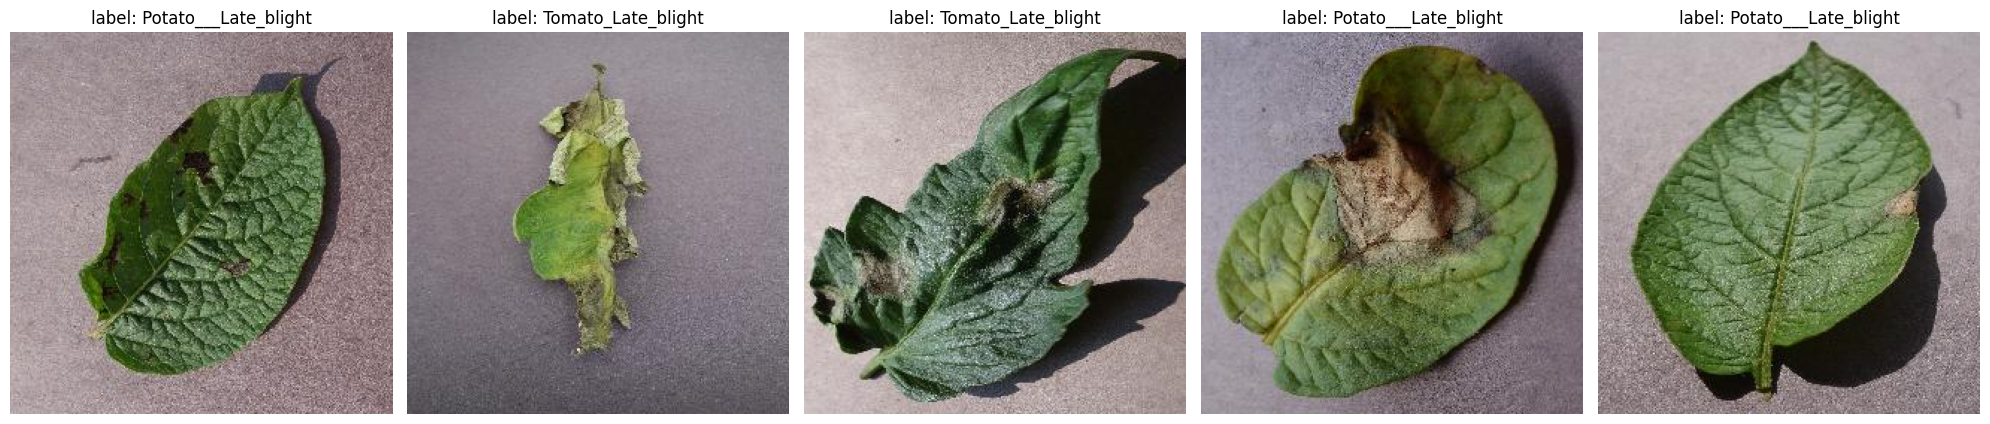

In [32]:
plt.figure(figsize=(20, 15))

for i in range(5):
    plt.subplot(1, 5, i + 1)
    index = np.random.choice(df.index)
    filename = df.loc[index, 'data']
    category = df.loc[index, 'label']
    img = Image.open(filename)
    plt.imshow(img)
    plt.title(f'label: {category}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [35]:
def extract_hog_features(image):
    # Convert the image to grayscale using cv2
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    hog = cv2.HOGDescriptor()

    # Compute HOG features
    hog_features = hog.compute(gray_image)

    return hog_features.flatten()

# Resize function to downsample images
def resize_image(image, new_size=(128, 128)):
    return cv2.resize(image, new_size)

In [36]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [42]:
batch_size = 32  # Adjust batch size based on memory constraints
features_list = []
labels_list = []

for start in range(0, len(df_shuffled), batch_size):
    end = min(start + batch_size, len(df_shuffled))
    batch = df_shuffled[start:end]

    batch_features = []
    batch_labels = []

    for index, row in batch.iterrows():
        image = cv2.imread(row['data'])
        resized_image = resize_image(image)  # Resize image to smaller dimensions
        hog_features = extract_hog_features(resized_image)
        batch_features.append(hog_features)
        batch_labels.append(row['label'])

    features_list.extend(batch_features)
    labels_list.extend(batch_labels)

In [44]:
# Convert lists to NumPy arrays
features_array = np.array(features_list)
labels_array = np.array(labels_list)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)

#print("Shape of extracted HOG features:", features_scaled.shape)

In [40]:
len(labels_encoded)

NameError: name 'labels_encoded' is not defined

In [45]:
np.unique(labels_encoded)

array([0, 1, 2])

In [47]:
X_train, X_test, y_train, y_test = train_test_split(features_array, labels_encoded,
                                                    test_size=0.25, random_state=42 ,
                                                    stratify = labels_encoded)

In [48]:
print(type(X_train), X_train.shape)
print(type(y_train), y_train.shape)
print(type(X_test), X_test.shape)
print(type(y_test), y_test.shape)

<class 'numpy.ndarray'> (2929, 34020)
<class 'numpy.ndarray'> (2929,)
<class 'numpy.ndarray'> (977, 34020)
<class 'numpy.ndarray'> (977,)


In [49]:
lr_pipeline = Pipeline([
    ('pca', PCA(n_components=2100,random_state=42)),
    ('classifier', LogisticRegression(max_iter = 1000,random_state=42))
])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pca', PCA(n_components=2100, random_state=42)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [50]:
predictions = lr_pipeline.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8782


In [52]:
report = classification_report(y_test, predictions, output_dict=True,zero_division=1)

# Convert the report to a pandas DataFrame for better visualization
report = pd.DataFrame(report).transpose()
report

,precision,recall,f1-score,support
0,0.882353,0.843373,0.862423,249.000000
1,0.867769,0.840000,0.853659,250.000000
2,0.881288,0.916318,0.898462,478.000000
accuracy,0.878199,0.878199,0.878199,0.878199
macro avg,0.877136,0.866564,0.871514,977.000000
weighted avg,0.878100,0.878199,0.877812,977.000000


In [53]:
# make a workflow
## save the processed data
## save trained model:: make it modular so can do RF, and others
### do image models

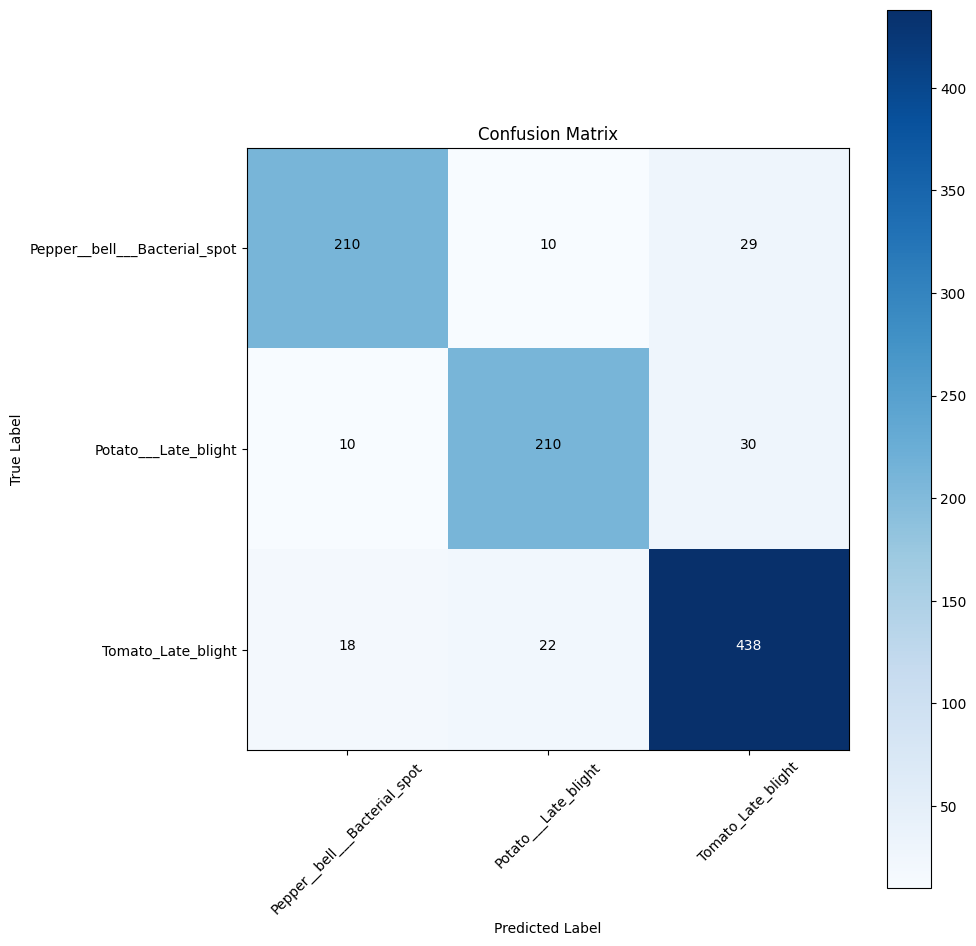

In [55]:
classes = selected_classes


cm = confusion_matrix(y_test, predictions)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center',
             color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# save the plot locally by model and other params
plt.show()

In [57]:
#[] select the misclassified files  and viz them

In [58]:
images = []
for index2, row2 in df.iterrows():
        image = cv2.imread(row2['data'])
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(gray_image)

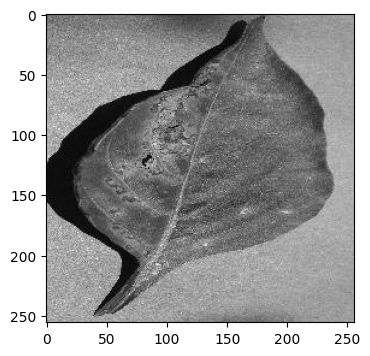

In [59]:
selected_image = images[0]

# Display the image using matplotlib
plt.figure(figsize=(4, 4))
plt.imshow(selected_image, cmap='gray')
plt.show()

In [60]:
images = np.array(images)

In [61]:
data = images.reshape((len(images), -1))

In [62]:
km = KMeans(n_clusters=3, random_state=42, n_init="auto")

In [63]:
km.fit_predict(data)

array([2, 0, 2, ..., 2, 1, 0], dtype=int32)

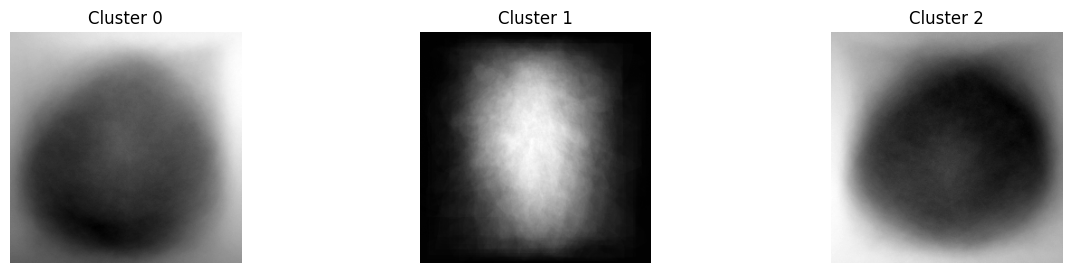

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(15, 3))

for i in range(3):
    center_image = km.cluster_centers_[i].reshape(256, 256)  # Reshape to original dimensions
    ax[i].imshow(center_image, cmap='gray')
    ax[i].axis('off')
    ax[i].set_title(f'Cluster {i}')

plt.show()

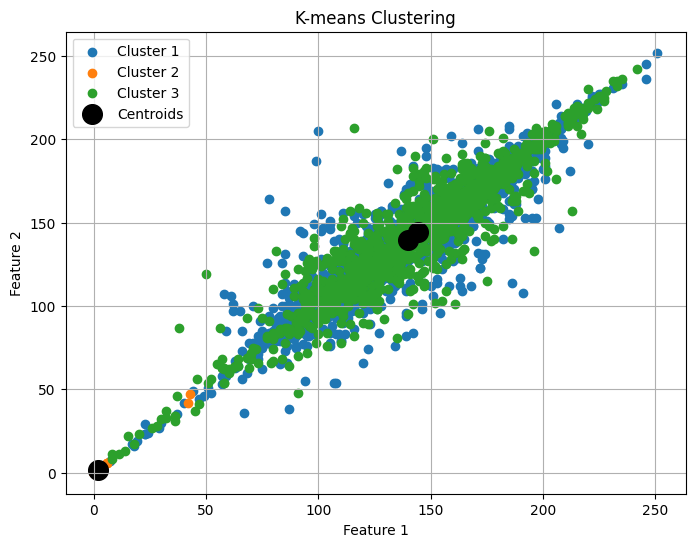

In [65]:
# Plotting the clustered data
plt.figure(figsize=(8, 6))
cluster_labels = km.labels_
# Scatter plot for each cluster
for cluster in range(3):
    plt.scatter(
        data[cluster_labels == cluster, 0],
        data[cluster_labels == cluster, 1],
        label=f'Cluster {cluster + 1}'
    )

# Plotting centroids if needed
centroids = km.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], marker='o', s=200, color='black', label='Centroids')

plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()
#[] do this for all the classes